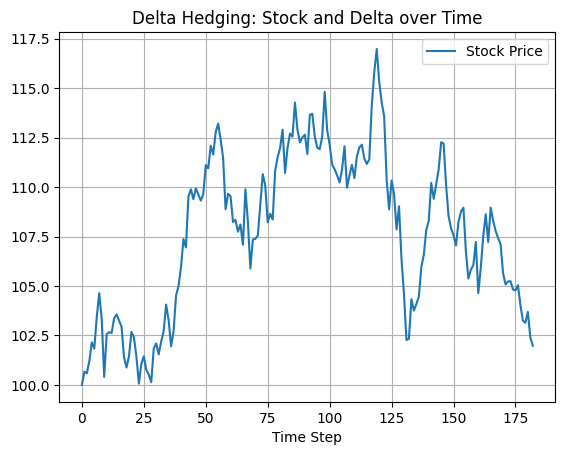

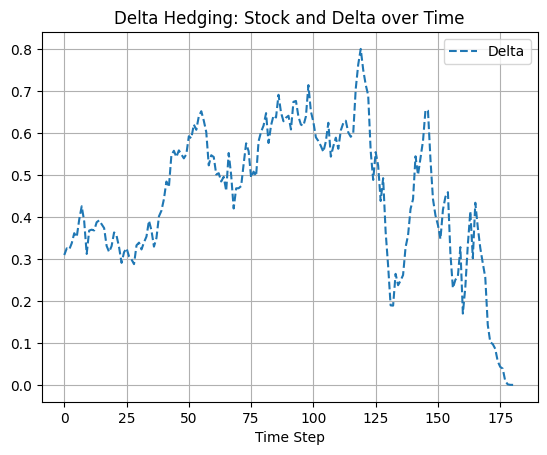

Hedging Error: -0.5822


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parameters
S0 = 100       # Initial stock price
K = 110        # Strike price
T = 0.5        # Time to maturity
r = 0.03       # Risk-free rate
sigma = 0.2    # Volatility
mu = 0.05      # Drift
nSteps = 182
dt = T / nSteps

# Function for Black-Scholes Delta
def bs_delta(S, K, T, r, sigma):
    if T == 0:
        return 1.0 if S > K else 0.0
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2)*T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)

# Function for Black-Scholes Price
def bs_price(S, K, T, r, sigma):
    if T == 0:
        return max(S - K, 0)
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2)*T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

# Simulate one GBM path
#np.random.seed(42)
S = [S0]
for _ in range(nSteps):
    dW = np.random.normal(0, np.sqrt(dt))
    S.append(S[-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * dW))

# Delta hedging
deltas = []
P = bs_price(S0, K, T, r, sigma)  # Receive option premium
shares = bs_delta(S0, K, T, r, sigma)
bank =P -  shares * S[0]
deltas.append(shares)

for i in range(1, len(S)-1):
    t = i * dt
    T_left = T - t
    delta_new = bs_delta(S[i], K, T_left, r, sigma)
    bank *= np.exp(r * dt)
    bank -= (delta_new - deltas[-1]) * S[i]
    deltas.append(delta_new)

# Final step
bank *= np.exp(r * dt)
bank += deltas[-1] * S[-1] - max(S[-1] - K, 0)
hedging_error = bank

# Plot stock path and deltas
plt.plot(S, label='Stock Price')
#plt.plot(deltas, label='Delta', linestyle='--')
plt.title("Delta Hedging: Stock and Delta over Time")
plt.xlabel("Time Step")
plt.grid(True)
plt.legend()
plt.show()

#plt.plot(S, label='Stock Price')
plt.plot(deltas, label='Delta', linestyle='--')
plt.title("Delta Hedging: Stock and Delta over Time")
plt.xlabel("Time Step")
plt.grid(True)
plt.legend()
plt.show()
print(f"Hedging Error: {hedging_error:.4f}")

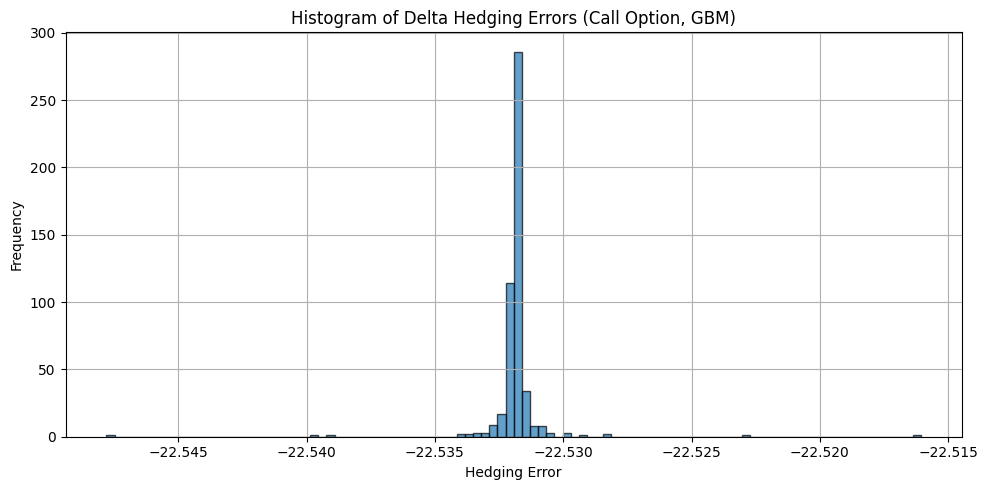

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parameters
S0 = 100          # Initial stock price
K = 80           # Strike price
T = 0.5          # Time to maturity (1 year)
r = 0.05          # Risk-free rate
mu = 0.08
sigma = 0.1       # Volatility
N = 100           # Number of time steps
M = 500          # Number of simulations
dt = T / N

# Arrays to store hedging errors
hedging_errors = []

# Black-Scholes delta function
def bs_delta(S, K, T, r, sigma, t):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * (T - t)) / (sigma * np.sqrt(T - t))
    return norm.cdf(d1)

# Black-Scholes call price function
def bs_call_price(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

# Simulation
for _ in range(M):
    S = np.zeros(N + 1)
    S[0] = S0
    for i in range(N):
        z = np.random.normal()
        S[i+1] = S[i] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)

    # Delta hedging
    #premium = bs_call_price(S0, K, T, r, sigma)
    premium = 0
    cash = premium - bs_delta(S0, K, T, r, sigma, 0) * S0
    stock = bs_delta(S0, K, T, r, sigma, 0)
    for i in range(1, N):
        t = i * dt
        delta_new = bs_delta(S[i], K, T, r, sigma, t)
        cash = cash * np.exp(r * dt) - (delta_new - stock) * S[i]
        stock = delta_new

    # Final portfolio value
    portfolio_value = cash * np.exp(r * dt) + stock * S[-1]
    option_payoff = max(S[-1] - K, 0)
    hedging_error = portfolio_value - option_payoff
    hedging_errors.append(hedging_error)

# Plot histogram of hedging errors
plt.figure(figsize=(10, 5))
plt.hist(hedging_errors, bins=100, edgecolor='black', alpha=0.7)
plt.title("Histogram of Delta Hedging Errors (Call Option, GBM)")
plt.xlabel("Hedging Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

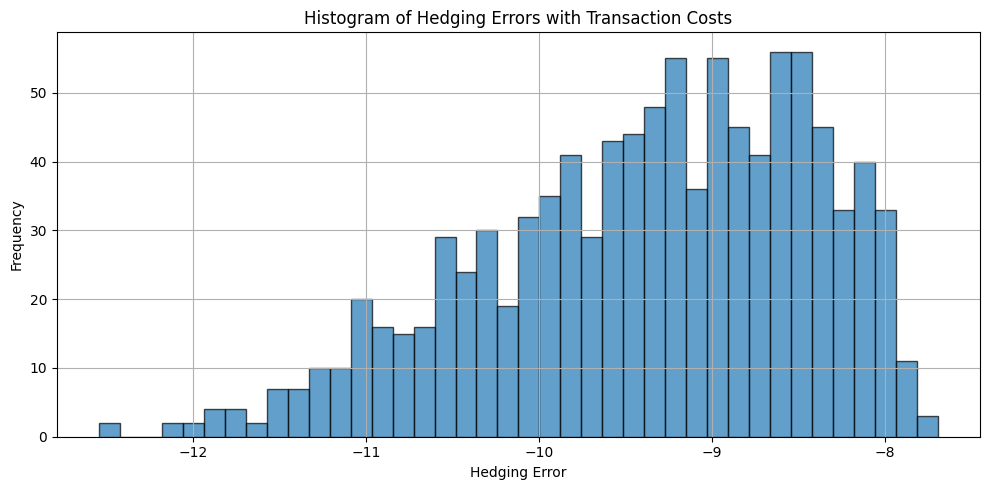

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parameters
S0 = 100         # Initial stock price
K = 100          # Strike price
T = 1.0          # Time to maturity
r = 0.05         # Risk-free rate
mu = 0.08
sigma = 0.1      # Volatility
N = 200          # Time steps
dt = T / N
simulations = 1000
transaction_cost_rate = 0.005  # 0.5% cost per trade

# Black-Scholes call delta
def bs_call_delta(S, K, T, r, sigma, t):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * (T - t)) / (sigma * np.sqrt(T - t))
    return norm.cdf(d1)

# Run simulations
hedging_errors = []

for _ in range(simulations):
    S = np.zeros(N + 1)
    S[0] = S0
    for i in range(N):
        dW = np.random.normal(0, np.sqrt(dt))
        S[i + 1] = S[i] * np.exp((mu - 0.5 * sigma ** 2) * dt + sigma * dW)

    deltas = np.array([bs_call_delta(S[i], K, T, r, sigma, i * dt) for i in range(N)])
    deltas = np.append(deltas, 0)  # No delta at expiry

    # Hedging with transaction cost
    shares_held = 0
    cash_account = 0
    for i in range(N):
        trade = deltas[i] - shares_held
        trade_cost = transaction_cost_rate * abs(trade) * S[i]
        cash_account *= np.exp(r * dt)
        cash_account -= trade * S[i] + trade_cost
        shares_held = deltas[i]

    final_portfolio = shares_held * S[N] + cash_account
    call_payoff = max(S[N] - K, 0)
    hedging_errors.append(final_portfolio - call_payoff)

# Plot histogram
plt.figure(figsize=(10, 5))
plt.hist(hedging_errors, bins=40, edgecolor='black', alpha=0.7)
plt.title("Histogram of Hedging Errors with Transaction Costs")
plt.xlabel("Hedging Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()